In [1]:
# Import all the liberaries that we need to use
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import matplotlib.pyplot as plt
import urllib.request

# Section 1) Fetch of the Kaggle Cats vs Dogs dataset (5%)

In [2]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0  6609k      0  0:02:01  0:02:01 --:--:-- 6622k02:39  0:00:03  0:02:36 5048k04  0:00:29  0:01:35 6869k:02  0:01:34  0:00:28 6510k02:01  0:01:37  0:00:24 6547k0:00:23 6868k


In [3]:
!unzip -q kagglecatsanddogs_3367a.zip
!ls

MSR-LA - 3467.docx          Yuan_week3.ipynb
PetImages                   kagglecatsanddogs_3367a.zip
README.md                   readme[1].txt
Untitled.ipynb              template.md
Yuan_week2.md


In [4]:
# Check there are two categories cat and dog in PetImages
!ls PetImages

Cat Dog


# Section 2) Coding of the convolutional neural network from scratch following the code example from keras.io (https://keras.io/examples/vision/image_classification_from_scratch/) (30%)

In [5]:
# Filter out corrupted images
num_skipped = 0
for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 1590 images


In [6]:
# Generate a Dataset
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


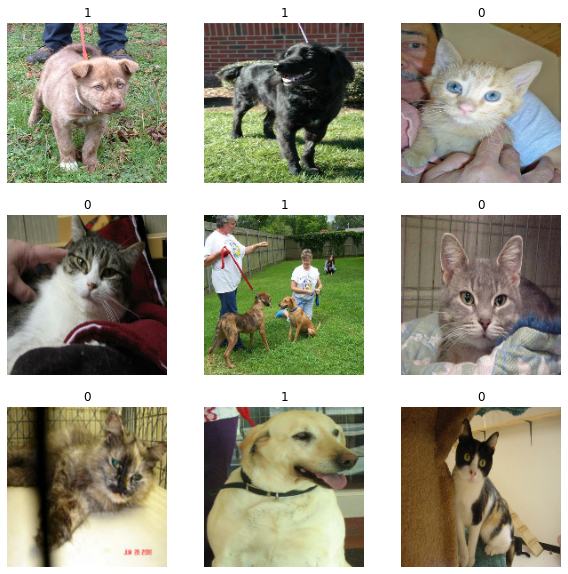

In [7]:
# Dataset Visualization, classified the cat and dog into 0 and 1
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [8]:
# Utilize image for data augmentation
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

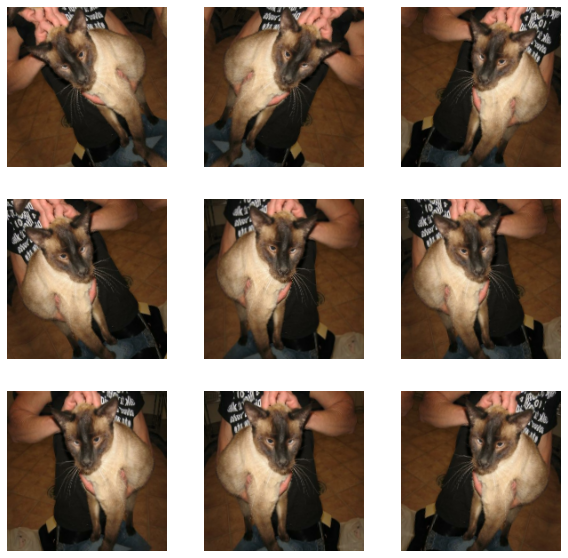

In [9]:
# visualize the augmented samples
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [10]:
# Configure the dataset for performance
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

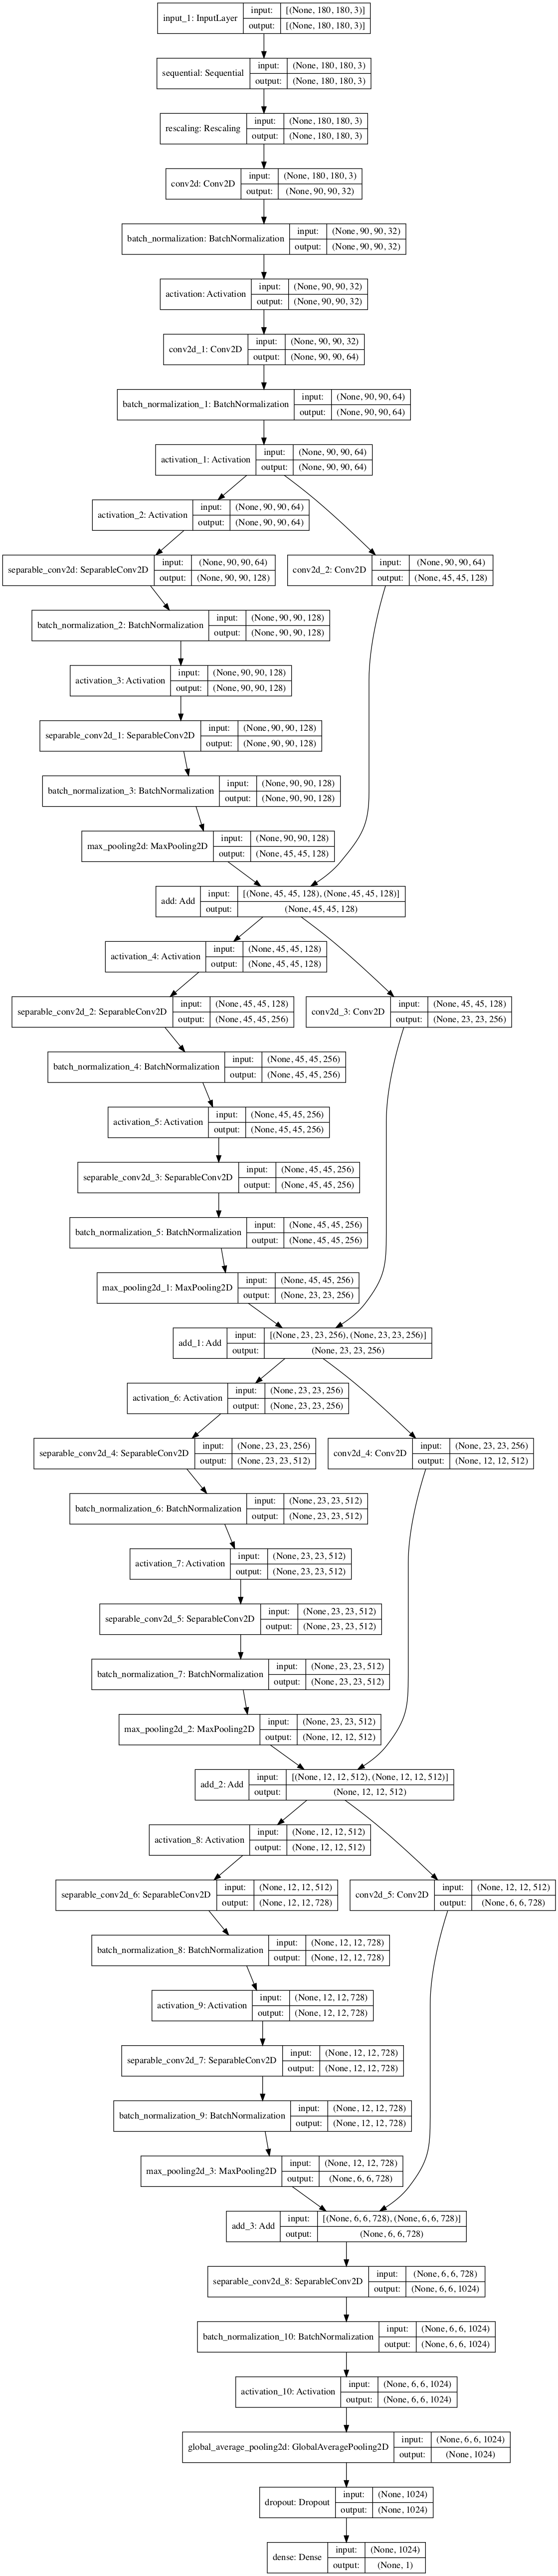

In [11]:
# Build the traning model
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

# Section 3) Calculation of the accuracy of the model with 25 epochs and then 50 epochs (15%)

In [12]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/25
586/586 [==============================] - 1995s 3s/step - loss: 0.6031 - accuracy: 0.6842 - val_loss: 0.6362 - val_accuracy: 0.6689


/Users/yuanchunhao/opt/anaconda3/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/25
586/586 [==============================] - 2088s 4s/step - loss: 0.4301 - accuracy: 0.8032 - val_loss: 0.9288 - val_accuracy: 0.5948
Epoch 3/25
586/586 [==============================] - 2079s 4s/step - loss: 0.3558 - accuracy: 0.8417 - val_loss: 0.3436 - val_accuracy: 0.8548
Epoch 4/25
586/586 [==============================] - 1823s 3s/step - loss: 0.2848 - accuracy: 0.8801 - val_loss: 0.2386 - val_accuracy: 0.8988
Epoch 5/25
586/586 [==============================] - 1923s 3s/step - loss: 0.2413 - accuracy: 0.8998 - val_loss: 0.6155 - val_accuracy: 0.7493
Epoch 6/25
586/586 [==============================] - 1902s 3s/step - loss: 0.2056 - accuracy: 0.9138 - val_loss: 0.2463 - val_accuracy: 0.8945
Epoch 7/25
586/586 [==============================] - 1936s 3s/step - loss: 0.1941 - accuracy: 0.9183 - val_loss: 0.2973 - val_accuracy: 0.8879
Epoch 8/25
586/586 [==============================] - 1756s 3s/step - loss: 0.1742 - accuracy: 0.9287 - val_loss: 0.2151 - val_accuracy:

In [13]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50
586/586 [==============================] - 1929s 3s/step - loss: 0.0874 - accuracy: 0.9655 - val_loss: 0.0972 - val_accuracy: 0.9601
Epoch 2/50
586/586 [==============================] - 1798s 3s/step - loss: 0.0866 - accuracy: 0.9656 - val_loss: 0.1426 - val_accuracy: 0.9417
Epoch 3/50
586/586 [==============================] - 1777s 3s/step - loss: 0.0792 - accuracy: 0.9700 - val_loss: 0.1161 - val_accuracy: 0.9543
Epoch 4/50
586/586 [==============================] - 1779s 3s/step - loss: 0.0809 - accuracy: 0.9683 - val_loss: 0.1007 - val_accuracy: 0.9633
Epoch 5/50
586/586 [==============================] - 1768s 3s/step - loss: 0.0790 - accuracy: 0.9679 - val_loss: 0.0991 - val_accuracy: 0.9613
Epoch 6/50
586/586 [==============================] - 1759s 3s/step - loss: 0.0791 - accuracy: 0.9689 - val_loss: 0.1167 - val_accuracy: 0.9551
Epoch 7/50
586/586 [==============================] - 1789s 3s/step - loss: 0.0786 - accuracy: 0.9695 - val_loss: 0.0805 - val_accuracy:

In [14]:
# According to the epoch we can see that the accuracy of epoch 25 is around 95.2%
# and the accuracy of epoch 50 is around 96.31%

# Section 4) Code an option that prompts the user for an image online (user to write the full URL of an image) (20%)

In [16]:
# Interact with the user, ask the URL and ask them to provide the file they download
# to calculate the accuracy
URL = input("Enter the URL where to find the picture: ")
picture = input("Provide the picture name that you saved in your computer: ")

Enter the URL where to find the picture: https://commons.wikimedia.org/wiki/File:Golden_Retriever_Hund_Dog.JPG
Provide the picture name that you saved in your computer: dog


# Section 5) Run your predictor model in the image from the URL submitted by the user and provide the best classification of whether the image is a dog or a cat. (30%)

In [20]:
img = keras.preprocessing.image.load_img(
    f"PetImages/Dog/{picture}.jpg", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = predictions[0]
print(
    "This image is %.2f percent cat and %.2f percent dog."
    % (100 * (1 - score), 100 * score)
)

This image is 0.00 percent cat and 100.00 percent dog.


In [18]:
# According to the result we can know the picture we doenload is 100% dog